# 2. Data Preprocessing & Temporal Data Splitting

DATA PREPROCESSING PIPELINE

[STEP 1] Loading data...
Loaded from AirQualityUCI.csv
  Original shape: (9357, 13)
  Date range: 2004-03-10 18:00:00 → 2005-04-04 14:00:00

[STEP 2] Replacing sentinel value -200 with NaN...
  Total -200 entries replaced: 16701

[STEP 3] Dropping NMHC(GT) (90.23% missing)...
  ✓ NMHC(GT) removed

[STEP 4] Handling missing values with tiered strategy...
Missing entries before: 8258
Missing after interpolation/ffill: 1535
Recovered values: 6723
Rows dropped (long gaps): 524
Final shape after cleaning: (8833, 12)

[STEP 5] Temporal split by year (no feature engineering)...
Train (2004) samples: 6602
Test  (2005) samples: 2231

[STEP 6] Saving preprocessed data...
Saved: ../output_Preprocessing_TemporalDataSplitting/preprocessed_data.csv
Saved: ../output_Preprocessing_TemporalDataSplitting/train_2004.csv
Saved: ../output_Preprocessing_TemporalDataSplitting/test_2005.csv

[STEP 7] Creating preprocessing summary figure...


/var/folders/t4/jlk_h9017j19858v6ybq5j680000gn/T/ipykernel_2572/2971860192.py:106: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method="ffill", limit=48)
/var/folders/t4/jlk_h9017j19858v6ybq5j680000gn/T/ipykernel_2572/2971860192.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(


Saved: ../output_Preprocessing_TemporalDataSplitting/Preprocessing_Summary.png

PREPROCESSING SUMMARY

Final cleaned samples : 8833
Train (2004) samples  : 6602
Test  (2005) samples  : 2231
Total sentinel -200 replaced : 16701
Missing recovered via interpolation/ffill : 6723
Rows dropped due to long gaps            : 524

Outputs written to: ../output_Preprocessing_TemporalDataSplitting

Downstream steps:
  - Use train_2004.csv for anomaly detection and feature engineering
  - Use test_2005.csv as held-out evaluation set
  - Use preprocessed_data_unnormalized.csv for label construction


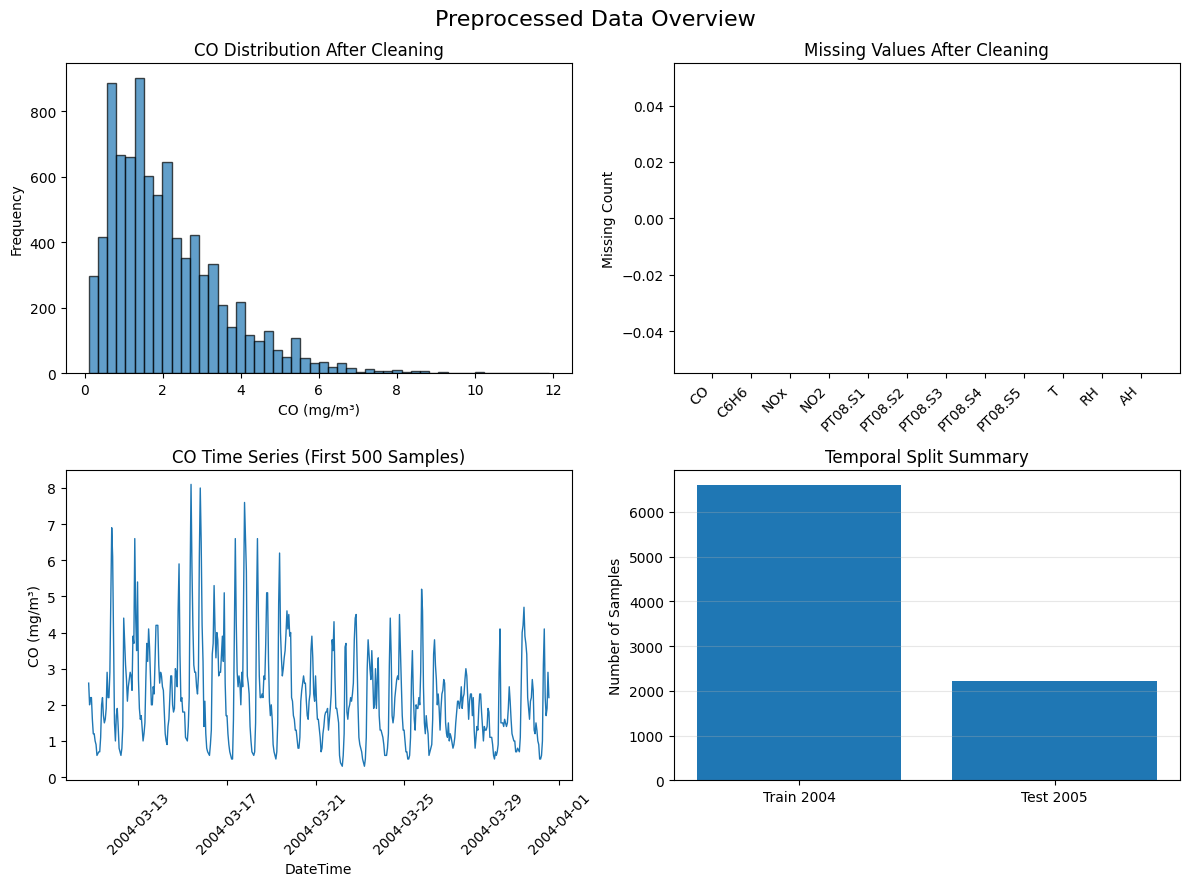

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Paths
# ------------------------------------------------------------------
PROJECT_ROOT = Path("..")
DATA_DIR = PROJECT_ROOT / "data_orig" / "data" / "air+quality"
OUTPUT_DIR = PROJECT_ROOT / "output_Preprocessing_TemporalDataSplitting"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 70)
print("DATA PREPROCESSING PIPELINE")
print("=" * 70)

# ------------------------------------------------------------------
# 1. Load raw data and build DateTime index
# ------------------------------------------------------------------
print("\n[STEP 1] Loading data...")

try:
    df = pd.read_excel(DATA_DIR / "AirQualityUCI.xlsx")
    print("Loaded from AirQualityUCI.xlsx")
except Exception:
    df = pd.read_csv(DATA_DIR / "AirQualityUCI.csv", sep=";", decimal=",")
    print("Loaded from AirQualityUCI.csv")

# Drop unnamed columns
df = df.loc[:, ~df.columns.str.contains(r"^Unnamed")]

# Handle Date/Time formats from both CSV and XLSX
if df["Date"].dtype == "object":
    dt = pd.to_datetime(
        df["Date"] + " " + df["Time"],
        format="%d/%m/%Y %H.%M.%S",
        errors="coerce",
    )
else:
    dt = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str))

df["DateTime"] = dt
df = df.dropna(subset=["DateTime"])
df = df.set_index("DateTime").sort_index()
df = df.drop(columns=["Date", "Time"])

print(f"  Original shape: {df.shape}")
print(f"  Date range: {df.index.min()} → {df.index.max()}")

# ------------------------------------------------------------------
# 2. Replace sentinel values (-200 → NaN)
# ------------------------------------------------------------------
print("\n[STEP 2] Replacing sentinel value -200 with NaN...")

numeric_cols = df.select_dtypes(include=[np.number]).columns
sentinel_counts = (df[numeric_cols] == -200.0).sum().sum()

for col in numeric_cols:
    df[col] = df[col].replace(-200.0, np.nan)

print(f"  Total -200 entries replaced: {sentinel_counts}")

# ------------------------------------------------------------------
# 3. Drop NMHC(GT) (heavy missingness)
# ------------------------------------------------------------------
print("\n[STEP 3] Dropping NMHC(GT) (90.23% missing)...")

if "NMHC(GT)" in df.columns:
    df = df.drop(columns=["NMHC(GT)"])
    print("  ✓ NMHC(GT) removed")

# ------------------------------------------------------------------
# 4. Tiered imputation by gap length
# ------------------------------------------------------------------
print("\n[STEP 4] Handling missing values with tiered strategy...")

pollutants = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
sensors = [
    "PT08.S1(CO)",
    "PT08.S2(NMHC)",
    "PT08.S3(NOx)",
    "PT08.S4(NO2)",
    "PT08.S5(O3)",
]
meteo = ["T", "RH", "AH"]

all_features = pollutants + sensors + meteo
all_features = [c for c in all_features if c in df.columns]

before_missing = df[all_features].isnull().sum().sum()
print(f"Missing entries before: {before_missing}")

# Linear interpolation for short gaps (≤ 6 hours)
for col in all_features:
    df[col] = df[col].interpolate(
        method="linear",
        limit=6,
        limit_direction="both",
    )

# Forward fill for medium gaps (7–48 hours)
for col in all_features:
    df[col] = df[col].fillna(method="ffill", limit=48)

after_interpolation = df[all_features].isnull().sum().sum()
recovered = before_missing - after_interpolation
print(f"Missing after interpolation/ffill: {after_interpolation}")
print(f"Recovered values: {recovered}")

# Drop rows with remaining long gaps (> 48 hours)
rows_before = len(df)
df = df.dropna(subset=all_features)
rows_after = len(df)

print(f"Rows dropped (long gaps): {rows_before - rows_after}")
print(f"Final shape after cleaning: {df.shape}")

# ------------------------------------------------------------------
# 5. Year-based temporal split (2004 train, 2005 test)
# ------------------------------------------------------------------
print("\n[STEP 5] Temporal split by year (no feature engineering)...")

years = df.index.year
train_mask = years == 2004
test_mask = years == 2005

train_df = df.loc[train_mask].copy()
test_df = df.loc[test_mask].copy()

print(f"Train (2004) samples: {train_df.shape[0]}")
print(f"Test  (2005) samples: {test_df.shape[0]}")

# ------------------------------------------------------------------
# 6. Save cleaned data and splits (unnormalised)
# ------------------------------------------------------------------
print("\n[STEP 6] Saving preprocessed data...")

# Full cleaned dataset (used later for label construction etc.)
df.to_csv(OUTPUT_DIR / "preprocessed_data.csv")
print(f"Saved: {OUTPUT_DIR/'preprocessed_data.csv'}")

# Year-based splits for downstream anomaly detection and feature engineering
train_df.to_csv(OUTPUT_DIR / "train_2004.csv")
test_df.to_csv(OUTPUT_DIR / "test_2005.csv")
print(f"Saved: {OUTPUT_DIR/'train_2004.csv'}")
print(f"Saved: {OUTPUT_DIR/'test_2005.csv'}")

# ------------------------------------------------------------------
# 7. Simple summary visualisation (optional figure for appendix)
# ------------------------------------------------------------------
print("\n[STEP 7] Creating preprocessing summary figure...")

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.suptitle("Preprocessed Data Overview", fontsize=16)

# (a) CO distribution after cleaning
axes[0, 0].hist(df["CO(GT)"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0, 0].set_xlabel("CO (mg/m³)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("CO Distribution After Cleaning")

# (b) Missing counts per key feature (after cleaning)
missing_per_feature = df[all_features].isnull().sum()
axes[0, 1].bar(all_features, missing_per_feature)
axes[0, 1].set_xticklabels(
    [c.split("(")[0] for c in all_features],
    rotation=45,
    ha="right",
)
axes[0, 1].set_ylabel("Missing Count")
axes[0, 1].set_title("Missing Values After Cleaning")

# (c) Sample CO time series
sample = df["CO(GT)"].iloc[:500]
axes[1, 0].plot(sample.index, sample.values, linewidth=1.0)
axes[1, 0].set_xlabel("DateTime")
axes[1, 0].set_ylabel("CO (mg/m³)")
axes[1, 0].set_title("CO Time Series (First 500 Samples)")
axes[1, 0].tick_params(axis="x", rotation=45)

# (d) Train/test size comparison
axes[1, 1].bar(["Train 2004", "Test 2005"], [len(train_df), len(test_df)])
axes[1, 1].set_ylabel("Number of Samples")
axes[1, 1].set_title("Temporal Split Summary")
axes[1, 1].grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(
    OUTPUT_DIR / "Preprocessing_Summary.png",
    dpi=300,
    bbox_inches="tight",
)
print(f"Saved: {OUTPUT_DIR/'Preprocessing_Summary.png'}")

# ------------------------------------------------------------------
# 8. Text summary
# ------------------------------------------------------------------
print("\n" + "=" * 70)
print("PREPROCESSING SUMMARY")
print("=" * 70)

print(f"\nFinal cleaned samples : {len(df)}")
print(f"Train (2004) samples  : {len(train_df)}")
print(f"Test  (2005) samples  : {len(test_df)}")
print(f"Total sentinel -200 replaced : {sentinel_counts}")
print(f"Missing recovered via interpolation/ffill : {recovered}")
print(f"Rows dropped due to long gaps            : {rows_before - rows_after}")

print(f"\nOutputs written to: {OUTPUT_DIR}")
print("\nDownstream steps:")
print("  - Use train_2004.csv for anomaly detection and feature engineering")
print("  - Use test_2005.csv as held-out evaluation set")
print("  - Use preprocessed_data_unnormalized.csv for label construction")